In [1]:
import numpy as np
from importlib import reload
import interpolate_fhat_Jhat as intf
import matplotlib.pyplot as plt
import calculate_Gamma 
from scipy.interpolate import interp1d, splev, splrep
from scipy.optimize import differential_evolution, curve_fit
from statistics import stdev

### Theoretical predictions

In [2]:
z_range = np.linspace(0,2,100)

#Predictions in a LCDM Universe without any fifth force present
fhat_LCDM = calculate_Gamma.fhat_LCDM(z_range) 
fhat_der_LCDM = np.gradient(fhat_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z
    
dlnf_LCDM = fhat_der_LCDM * (1+z_range)/fhat_LCDM    

Jhat_LCDM = calculate_Gamma.Jhat_LCDM(z_range)
Jhat_der_LCDM = np.gradient(Jhat_LCDM, z_range, axis=0, edge_order=2 ) #derivative wrt z

In [3]:
fhat_der = interp1d(z_range, fhat_der_LCDM)

In [4]:
dlnf_LCDM = fhat_der_LCDM*(1+z_range)/fhat_LCDM

### Jhat LSST and fhat DESI predictions

In [5]:
#Jhat from LSST, see arXiv:2312.06434 
z_LSST = np.array([0.25, 0.38, 0.51, 0.65, 0.79, 0.95, 1.13, 1.35, 1.7, 2.1])

#See Tables 2.3 & 2.5 for the DESI values (for fhat)
z_DESI = np.array([0.15, 0.25, 0.35, 0.45, 
                  0.65, 0.75, 0.85, 0.95, 1.05,
                  1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85]) #removed first entry z=0.05 

In [6]:
Jhat_fiducial = calculate_Gamma.Jhat_LCDM(z_LSST) 
fhat_fiducial = calculate_Gamma.fhat_LCDM(z_DESI)

In [7]:
# This is the covariance obtained in arXiv:2209.08987 for Jhat from LSST in the pessimistic case 
Jhat_covariance_pess = np.array([
    [2.57951701e-06, 3.43714013e-06, 3.78596653e-06, 3.97457043e-06, 4.18816362e-06, 4.39505164e-06, 4.47790648e-06, 4.47700806e-06, 4.24858437e-06, 3.87759857e-06],
    [3.43714013e-06, 5.76832795e-06, 6.54476977e-06, 6.95571576e-06, 7.45270358e-06, 7.92270577e-06, 8.13695089e-06, 8.20293470e-06, 7.69384687e-06, 6.90754476e-06],
    [3.78596653e-06, 6.54476977e-06, 8.11838970e-06, 8.63298312e-06, 9.17778834e-06, 9.77833733e-06, 1.00747736e-05, 1.01941775e-05, 9.52407086e-06, 8.50424121e-06],
    [3.97457043e-06, 6.95571576e-06, 8.63298312e-06, 9.83424932e-06, 1.03745319e-05, 1.09043993e-05, 1.12436536e-05, 1.14074618e-05, 1.06360913e-05, 9.46716355e-06],
    [4.18816362e-06, 7.45270358e-06, 9.17778834e-06, 1.03745319e-05, 1.16363619e-05, 1.20980641e-05, 1.22994565e-05, 1.24745875e-05, 1.16153781e-05, 1.03213691e-05],
    [4.39505164e-06, 7.92270577e-06, 9.77833733e-06, 1.09043993e-05, 1.20980641e-05, 1.34344629e-05, 1.34470640e-05, 1.34194239e-05, 1.24643638e-05, 1.10630734e-05],
    [4.47790648e-06, 8.13695089e-06, 1.00747736e-05, 1.12436536e-05, 1.22994565e-05, 1.34470640e-05, 1.45726282e-05, 1.41793590e-05, 1.29215851e-05, 1.14578205e-05],
    [4.47700806e-06, 8.20293470e-06, 1.01941775e-05, 1.14074618e-05, 1.24745875e-05, 1.34194239e-05, 1.41793590e-05, 1.54847524e-05, 1.35132383e-05, 1.16759455e-05],
    [4.24858437e-06, 7.69384687e-06, 9.52407086e-06, 1.06360913e-05, 1.16153781e-05, 1.24643638e-05, 1.29215851e-05, 1.35132383e-05, 1.53255587e-05, 1.18286623e-05],
    [3.87759857e-06, 6.90754476e-06, 8.50424121e-06, 9.46716355e-06, 1.03213691e-05, 1.10630734e-05, 1.14578205e-05, 1.16759455e-05, 1.18286623e-05, 2.78093215e-05]
])

In [8]:
Jhat_data_future_pess = {
    'mean' : Jhat_fiducial,
    'cov' : Jhat_covariance_pess,
}

In [9]:
# See Tables 2.3 & 2.5 for the DESI values (for fhat)
# Note: Relative errors multiplied by fhat_fiducial to get absolute errors
fhat_errors_opt = np.array([5.25, 3.25, 2.60, 3.77, 1.57, 1.01, 1.01, 0.99, 
                            1.11, 1.14, 1.16, 1.73, 1.87, 2.27, 3.61, 6.81, 7.07])/100*fhat_fiducial #removed first entry 14.08
fhat_covariance_opt = np.diag(fhat_errors_opt**2)

fhat_data_future = {
    'z' : z_DESI,
    'mean' : fhat_fiducial,
    'cov' : fhat_covariance_opt,
    'err' : fhat_errors_opt
}

In [10]:
Jhat_errors_pess = np.sqrt(np.diag(Jhat_covariance_pess))

### Spline reconstruction of fhat

#### Checking the AIC and BIC for different sets of knots

In [11]:
def IC(best_fit_values, zarray, k=3):
    chi_squared = intf.chi_squared_spline(best_fit_values, zarray, k=k,  z_data = z_DESI, fhat_data = fhat_fiducial, 
                                          fhat_data_errors = fhat_errors_opt, fhat_data_covariance = fhat_covariance_opt)
    AIC = 2*len(zarray)+2*chi_squared
    BIC= np.log(len(z_DESI))*len(zarray)+2*chi_squared
    return [chi_squared, AIC, BIC]    

In [12]:
# Check AIC, BIC and chi squared values for different numbers of knots

AIC_values=[]
BIC_values=[]
chi_squared_values=[]
k=3

for n in range(3,15):
    z_test=np.linspace(0,2,n)
    [best_fit_values_test, covariance_matrix_test] = intf.minuit_spline(z_test, k=k, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
    [chi_squared, AIC, BIC]=IC(best_fit_values_test, z_test, k=k)
    chi_squared_values.append(chi_squared)
    AIC_values.append(AIC)
    BIC_values.append(BIC)
    
print(chi_squared_values)
print(AIC_values)
print(BIC_values)

[5.261730673041713, 0.3380236826735858, 0.017227785570982933, 0.0012091686511980222, 6.692545318956491e-05, 7.531461287031104e-05, 0.00011922313043206793, 1.2840908469814447e-06, 6.0063407305346156e-06, 2.0568309203586028e-05, 6.934529751655553e-06, 1.3454417074174781e-05]
[16.523461346083426, 8.676047365347172, 10.034455571141965, 12.002418337302396, 14.00013385090638, 16.00015062922574, 18.000238446260862, 20.000002568181692, 22.00001201268146, 24.000041136618407, 26.000013869059504, 28.000026908834148]
[19.023101378252075, 12.008900741572036, 14.200522291423045, 17.001698401639693, 19.832627259299894, 22.66585738167547, 25.499158542766807, 28.332136008743852, 31.165358797299838, 33.998601265293004, 36.83178734179031, 39.66501372562118]


In [13]:
# Minimize the chi squared value for the fixed case of 5 knots

# Define the objective function to minimize
def objective(zarray):
    zarray = np.sort(np.ravel(zarray))
    best_fit_values_test, _ = intf.minuit_spline(zarray, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
    return intf.chi_squared_spline(best_fit_values_test, np.sort(zarray), z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt) # Sort to ensure increasing order

# Bounds for each of the 5 redshift values (assuming they must be in [0,2])
bounds = [(0, 2)] * 5  # 5 values, each between 0 and 2

# Run differential evolution to find the optimal placement
result = differential_evolution(objective, bounds, strategy='best1bin', 
                                popsize=15, tol=1e-6, maxiter=10)

# Optimal zarray values
optimal_zarray = np.sort(result.x)

print("Optimal zarray:", optimal_zarray)
print("Minimum chi-squared:", result.fun)

Optimal zarray: [0.48954574 0.66723628 0.87397361 1.01526546 1.80372609]
Minimum chi-squared: 0.006578800809386699


In [14]:
best_fit_values_optimal, _ = intf.minuit_spline(optimal_zarray, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt)
print("Minimum AIC:", IC(best_fit_values_optimal, optimal_zarray))

Minimum AIC: [0.006578800809386699, 10.013157601618774, 14.179224321899854]


#### Spline reconstruction with optimal set of five knots, and comparison case with four knots

In [15]:
# Setting the five knot values; 
# Note: Only the placement one of the central one affects the reconstruction;
# The other ones can be chosen randomly.
knot_values = np.array([0.1, 0.8, 0.87397377, 1.0, 1.8]) 

# Generate best fit values (for fhat at knots) and cov matrix
[best_fit_spline, cov_spline] = intf.minuit_spline(knot_values, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt )

# Reconstruction over the whole redshift range
fhat_spline_reco = intf.spline_reconstruction(best_fit_spline, cov_spline, zarray = knot_values, z_range = z_range, return_covariance = True)

# Reconstruction at LSST redshifts
fhat_spline_reco_LSST = intf.spline_reconstruction(best_fit_spline, cov_spline, zarray = knot_values, z_range = z_LSST, return_covariance = True)

In [16]:
# Spline interpolation with 4 knots (as a comparison)
# Note: Placement of these 4 knots does not influence the reconstruction
four_knot_values = np.array([0.5, 1.0, 1.5, 2.0])

# Generate best fit values (for fhat at knots) and cov. matrix
[best_fit_spline_4knots, cov_spline_4knots] = intf.minuit_spline(four_knot_values, z_data = z_DESI, fhat_data = fhat_fiducial, fhat_data_errors = fhat_errors_opt )

# Reconstruction over the whole redshift range
fhat_spline_reco_4knots = intf.spline_reconstruction(best_fit_spline_4knots, cov_spline_4knots, zarray = four_knot_values, z_range = z_range, return_covariance = True)
fhat_spline_reco_LSST_4knots = intf.spline_reconstruction(best_fit_spline_4knots, cov_spline_4knots, zarray = four_knot_values, z_range = z_LSST, return_covariance = True)

In [17]:
# Standard devs. for the reconstruction of fhat 
# Baseline case (5 knots)
fhat_stdev_spline = np.sqrt(np.diag(fhat_spline_reco['cov'])) # whole redshift range
fhat_stdev_spline_LSST = np.sqrt(np.diag(fhat_spline_reco_LSST['cov'])) #  at LSST redshifts

# Comparison (4 knots)
fhat_stdev_spline_4knots = np.sqrt(np.diag(fhat_spline_reco_4knots['cov'])) # whole redshift range
fhat_stdev_spline_LSST_4knots = np.sqrt(np.diag(fhat_spline_reco_LSST_4knots['cov'])) #  at LSST redshifts

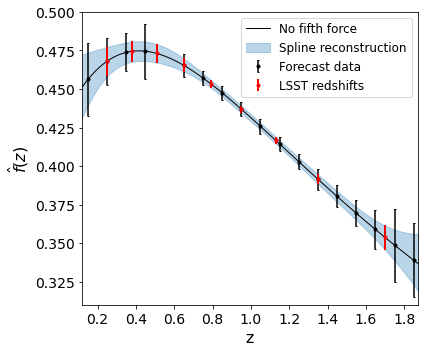

<Figure size 432x288 with 0 Axes>

In [18]:
### Plot reconstruction of fhat (baseline case) with inferred values at LSST redshifts
plt.figure(figsize=(6, 5))
plt.xlabel('z', fontsize=16)
plt.ylabel('$\\hat{f}(z)$', fontsize=16)

# Prediction with no fifth force
StandardPrediction = plt.plot(z_range, calculate_Gamma.fhat_LCDM(z_range), color = 'black',  linewidth = 1.0, label = 'No fifth force')[0]


# Data
plt.errorbar(fhat_data_future["z"], fhat_data_future["mean"], fhat_data_future["err"], fmt=".", capsize=1, 
             label="Forecast data", color='black')

# Spline reconstruction
plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_stdev_spline,
    fhat_spline_reco['mean'] + fhat_stdev_spline, color='C0', alpha=0.3, label = 'Spline reconstruction')

plt.errorbar(z_LSST[0:-1],fhat_spline_reco_LSST['mean'][:-1],fhat_stdev_spline_LSST[:-1],
             color = 'red', fmt=".", linewidth = 2, label = 'LSST redshifts')


plt.xlim(0.12,1.87)
plt.ylim(0.31,0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.savefig("fhat_future.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

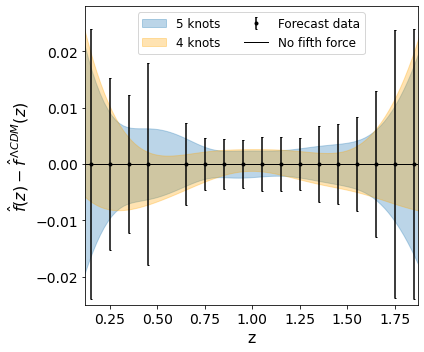

<Figure size 432x288 with 0 Axes>

In [20]:
### Plot of fhat, comparison between 5 knots and 4 knots

plt.figure(figsize=(6, 5))
plt.xlabel('z', fontsize=16)
plt.ylabel('$\\hat{f}(z)-\\hat{f}\\,{^{\\Lambda CDM}}(z)$', fontsize=16)

# data
data = plt.errorbar(fhat_data_future["z"][0:], fhat_data_future["mean"][0:]-fhat_data_future["mean"][0:], fhat_data_future["err"][0:], fmt=".", capsize=1, 
             label="Forecast data", color='black')

# Prediction without a fifth force
StandardPrediction = plt.plot([0,2], [0,0], color = 'black',  linewidth = 1.0, label = 'No fifth force')[0]

# Spline 1 (baseline with 5 knots)
fill1 = plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_LCDM - fhat_stdev_spline, fhat_spline_reco['mean'] - fhat_LCDM + fhat_stdev_spline, 
                 color='C0', alpha=0.3, label = '5 knots')

# Spline 2 (comparison case with 4 knots)

fill2 = plt.fill_between(z_range, fhat_spline_reco_4knots['mean'] - fhat_LCDM - fhat_stdev_spline_4knots, fhat_spline_reco_4knots['mean'] - fhat_LCDM + fhat_stdev_spline_4knots, 
                 color='orange', alpha=0.3, label = '4 knots')


ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]
plt.xlim(0.12,1.87)
plt.ylim(-0.025,0.028)
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)

handles = [fill1, fill2, data, StandardPrediction]
labels = ['5 knots', '4 knots', 'Forecast data', 'No fifth force']
plt.legend(handles, labels, fontsize=12, ncol=2, loc = 'upper center')

plt.tight_layout()
#plt.savefig("fhat_future_4_5.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

### Calculating dlnf(z) and Gamma(z) with covariances at LSST values

In [21]:
# The following computes \Gamma(z) and d\ln(\hat{f})(z)/d\ln(1+z) and their covariances at LSST redshifts
# Baseline case with 5 knots
[Gamma_LSST, Gamma_cov_LSST, dlnf_mean_LSST, dlnf_cov_LSST]=calculate_Gamma.Gamma_reco(fhat_spline_reco_LSST, Jhat_data_future_pess, include_cov01 = True)
err_Gamma_LSST = np.sqrt(np.diag(Gamma_cov_LSST))
err_dlnf_LSST = np.sqrt(np.diag(dlnf_cov_LSST))

# Comparison with 4 knots
[Gamma_LSST_4knots, Gamma_cov_LSST_4knots, dlnf_mean_LSST_4knots, dlnf_cov_LSST_4knots]=calculate_Gamma.Gamma_reco(fhat_spline_reco_LSST_4knots, Jhat_data_future_pess, include_cov01 = True)
err_Gamma_LSST_4knots = np.sqrt(np.diag(Gamma_cov_LSST_4knots))
err_dlnf_LSST_4knots = np.sqrt(np.diag(dlnf_cov_LSST_4knots))

### Reconstruction of dln(f) over whole redshift range

In [22]:
# The following computes d\ln(\hat{f})(z)/d\ln(1+z) and its covariance in the whole redshift range
# Baseline case with 5 knots
[dlnf_mean, dlnf_cov] = calculate_Gamma.dlnf_dln1pz(fhat_spline_reco, include_cov01 = True)
err_dlnf = np.sqrt(np.diag(dlnf_cov))

# Comparison with 4 knots
[dlnf_mean_4knots, dlnf_cov_4knots] = calculate_Gamma.dlnf_dln1pz(fhat_spline_reco_4knots, include_cov01 = True)
err_dlnf_4knots = np.sqrt(np.diag(dlnf_cov_4knots))

Text(0, 0.5, '$\\mathrm{d}\\,\\ln\\hat{f}(z)/\\mathrm{d}\\,\\ln(1+z)$')

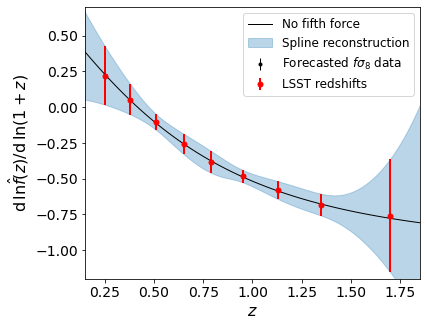

In [23]:
# Plotting d\ln(\hat{f})(z)/d\ln(1+z) for the baseline case (5 knots), showing DESI redshifts

plt.figure(figsize=(6, 5))

plt.errorbar([1], [-10], yerr = [0.01], fmt = '.', label = 'Forecasted $f\sigma_8$ data', color = 'black', elinewidth=1)
plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


plt.errorbar(z_LSST, dlnf_mean_LSST, yerr=err_dlnf_LSST, fmt='.', markersize=10, elinewidth=2, 
             color = 'red', label = 'LSST redshifts')

plt.fill_between(
    fhat_spline_reco['x'],
    dlnf_mean - err_dlnf,
     dlnf_mean + err_dlnf,
    color='C0',
    alpha=0.3,
    label = 'Spline reconstruction'
)


plt.xlim(0.15,1.85) #min. and max. z values of DESI data
plt.ylim(-1.2,0.7)

plt.legend(fontsize = 12)

ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)

#plt.savefig("dlnf_forecast.png", dpi=600, bbox_inches='tight')

Text(0, 0.5, '$\\mathrm{d}\\,\\ln\\hat{f}(z)/\\mathrm{d}\\,\\ln(1+z)$')

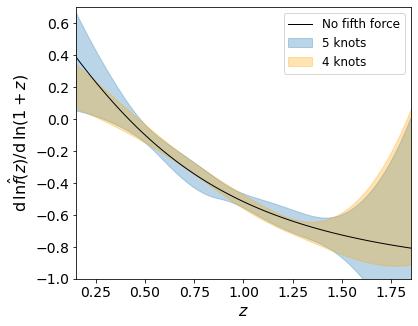

In [24]:
# Plotting d\ln(\hat{f})(z)/d\ln(1+z), comparing the baseline case (5 knots) with 4 knots

plt.figure(figsize=(6, 5))

StandardPrediction = plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


fill1 = plt.fill_between(
    fhat_spline_reco['x'],
    dlnf_mean - err_dlnf,
     dlnf_mean + err_dlnf,
    color='C0',
    alpha=0.3,
    label = '5 knots'
)

fill2 = plt.fill_between(
    fhat_spline_reco_4knots['x'],
    dlnf_mean_4knots - err_dlnf_4knots,
     dlnf_mean_4knots + err_dlnf_4knots,
    color='orange',
    alpha=0.3,
    label = '4 knots'
)


plt.xlim(0.15,1.85) #min. and max. z values of DESI data
plt.ylim(-1.0,0.7)
plt.legend(fontsize = 12)
ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln\hat{f}(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)

#plt.savefig("dlnf_forecast_4_5.png", dpi=600, bbox_inches='tight')

### Reconstruction of Jhat over whole redshift range

In [25]:
knot_values_J = z_LSST

# Generate best fit values (for fhat at knots) and cov matrix
[J_best_fit_spline, J_cov_spline] = intf.minuit_spline(knot_values_J, z_data = z_LSST, fhat_data = Jhat_fiducial, fhat_data_covariance = Jhat_covariance_pess, use_covariance = True)

# Reconstruction over the whole redshift range
Jhat_spline_reco = intf.spline_reconstruction(J_best_fit_spline, J_cov_spline, zarray = knot_values_J, z_range = z_range, return_covariance = True)
Jhat_spline_reco_knots = intf.spline_reconstruction(J_best_fit_spline, J_cov_spline, zarray = knot_values_J, z_range = knot_values, return_covariance = True)

In [26]:
Jhat_stdev_spline = np.sqrt(np.diag(Jhat_spline_reco['cov']))

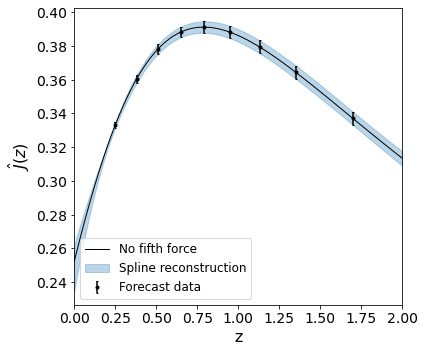

<Figure size 432x288 with 0 Axes>

In [27]:
### Plot of Jhat with reconstruction
plt.figure(figsize=(6, 5))
plt.xlabel('z', fontsize=16)
plt.ylabel('$\\hat{J}(z)$', fontsize=16)

# data
plt.errorbar(z_LSST, Jhat_fiducial, np.sqrt(np.diag(Jhat_covariance_pess)), fmt=".", capsize=1, 
             label="Forecast data", color='black')

# Theoretical prediction
plt.plot(z_range, Jhat_LCDM, color = 'black',  linewidth = 1, label = 'No fifth force')

# spline
plt.fill_between(z_range, (Jhat_spline_reco['mean'] - Jhat_stdev_spline), (Jhat_spline_reco['mean'] + Jhat_stdev_spline), 
                 color='C0', alpha=0.3, label = 'Spline reconstruction')

ticks = [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
plt.xticks(ticks,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,2)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.savefig("Jhat_future.png", dpi=600, bbox_inches='tight')
plt.show()
plt.clf()

### Computing Gamma over the whole redshift range

In [28]:
# Baseline case with 5 knots
[Gamma_range, Gamma_cov_range]=calculate_Gamma.Gamma_reco(fhat_spline_reco, Jhat_spline_reco,  output_dlnz = False, include_cov01 = True)
err_Gamma_range = np.sqrt(np.diag(Gamma_cov_range))

# Comparison case with 4 knots
[Gamma_range_4knots, Gamma_cov_range_4knots]=calculate_Gamma.Gamma_reco(fhat_spline_reco_4knots, Jhat_spline_reco,  output_dlnz = False, include_cov01 = True)
err_Gamma_range_4knots= np.sqrt(np.diag(Gamma_cov_range_4knots))

### Gamma

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 <a list of 7 Text major ticklabel objects>)

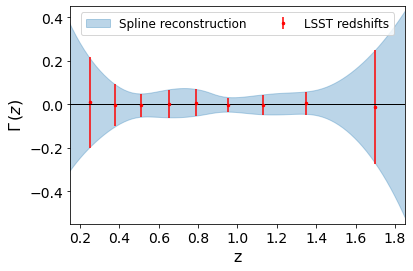

In [29]:
# plt.figure(figsize=(6, 5))

plt.plot(np.linspace(0.,2.0,50), np.full(50, 0), color='black', linewidth=1.0)


# Plot the measured data with larger markers and wider error bars
plt.fill_between(z_range, Gamma_range - 1-err_Gamma_range, Gamma_range - 1+err_Gamma_range, 
                 color = 'C0', alpha=0.3, label = 'Spline reconstruction')



# Plot the measured data with larger markers and wider error bars
plt.errorbar(z_LSST[:-1], Gamma_LSST[:-1] - 1, yerr=err_Gamma_LSST[:-1], fmt='.', markersize=5, 
             elinewidth=1.5, color = 'red', label = 'LSST redshifts')

plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.15,1.85)
plt.ylim(-0.55, 0.45)
plt.legend(ncol = 2, loc = 'upper center', fontsize = 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("results_Gamma_forecast.png", dpi=600, bbox_inches='tight')

(array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]),
 <a list of 8 Text major ticklabel objects>)

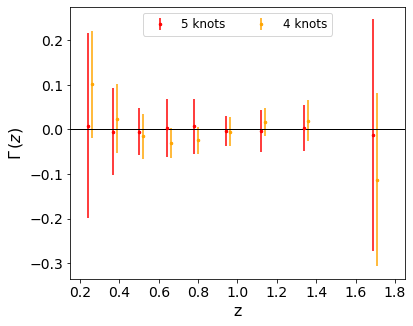

In [30]:
plt.figure(figsize=(6, 5))

plt.plot(np.linspace(0.,2.0,50), np.full(50, 0), color='black', linewidth=1.0)

# Plot the measured data with larger markers and wider error bars
plt.errorbar(z_LSST[:-1]-0.01, Gamma_LSST[:-1] - 1, yerr=err_Gamma_LSST[:-1], fmt='.', 
             markersize=5, elinewidth=1.5, color = 'red', label = '5 knots')
plt.errorbar(z_LSST[:-1]+0.01, Gamma_LSST_4knots[:-1] - 1, yerr=err_Gamma_LSST_4knots[:-1], fmt='.', 
             markersize=5, elinewidth=1.5, color = 'orange', label = '4 knots')
####

plt.xlabel("z", fontsize=16)
plt.ylabel("$\Gamma\,(z)$", fontsize=16)
plt.xlim(0.15,1.85)
#plt.ylim(-0.6, 0.4)
plt.legend(loc = 'upper center', fontsize = 12, ncol = 2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("results_Gamma_forecast_4_5.png", dpi=600, bbox_inches='tight')

### Testing Gaussian Processes

We check if Gaussian Processes are applicable to the future fhat data considered here, and find that it doesn't reconstruct fhat as well as the more standard spline reconstruction (especially in case of the derivative).

In [31]:
import os
#Download https://github.com/louisperenon/HCGP and then change the path accordingly
os.chdir('/Users/nastassiagrimm/Documents/GitHub/EG_project/Jhat_fhat') #parent directory of HCGP folder
os.chdir('./HCGP')
from kernels import SquaredExponential, RationalQuadratic, Matern32
from master import Engine
os.chdir('..')

In [32]:
#################
### GP config ###
#################
run_options = {
    "name_run": "test",
    "method": ["optimisation"],
    "print_chains": False,
    "print_plots": False,
}

gp_info = {
    "name_function": "fhat",
    "label_function": r"$\hat{f}(z)$",
    "label_x": r"$z$",
    "kernel": SquaredExponential(sigma="sigma1", xi="xi1"),
    "hyperpars": {
        "sigma1": {
            "label": r"\sigma",
            "range": [-5, 5], # this means that hyper parameter can range between -10^(5) and +10^5
            "sampling_invfunc": lambda x: 10 ** np.array(x),
        },
        "xi1": {
            "label": r"\xi",
            "range": [-5, 5],
            "sampling_invfunc": lambda x: 10 ** np.array(x),
        },
    },
    "mean_priors": {
        "mean": lambda x: 0 * x,
    },
    "derivatives": True,
}

In [33]:
# Gaussian process interpolation
fhat_data = {
        "x": z_DESI,
        "y": fhat_fiducial,
        "err": fhat_errors_opt/fhat_fiducial,
        "cov": np.diag((fhat_errors_opt/fhat_fiducial)**2),
    }

results = Engine(run_options, gp_info, fhat_data, True)
fhat_reco = results.get_optimised_reconstruction(z_range)
fhat_reco_LSST = results.get_optimised_reconstruction(z_LSST)


*** Minimisation results ***

> sigma1: bestfit = 0.3458041035339662; bestsamp = -0.4611698574137916 
> xi1: bestfit = 3.0518649854700977; bestsamp = 0.4845653165166816 
> maxlnl = 40.894021027262426



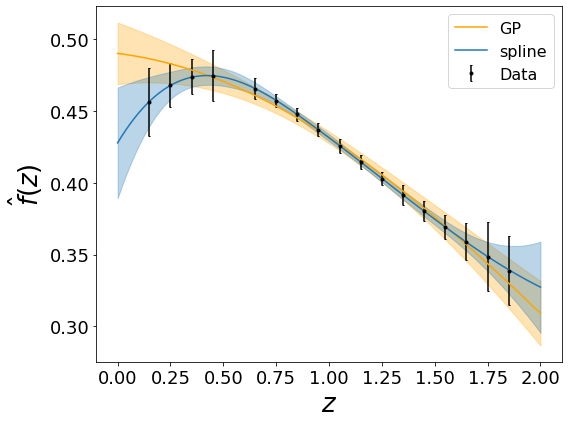

<Figure size 432x288 with 0 Axes>

In [34]:
### Plot comparing fhat interpolation for GP and spline interpolation
plt.figure(figsize=(8, 6))
plt.xlabel(gp_info["label_x"], fontsize=26)
plt.ylabel('$\\hat{f}(z)$', fontsize=26)
# data
plt.errorbar(fhat_data["x"], fhat_data["y"], fhat_data["err"]*fhat_data['y'], fmt=".", capsize=1, 
             label="Data", color='black')

# gp
plt.plot(fhat_reco["x"], fhat_reco["mean"], color='orange', label="GP")

plt.fill_between(fhat_reco["x"], fhat_reco["mean"] - fhat_reco["err"], fhat_reco["mean"] + fhat_reco["err"],
                 color='orange', alpha=0.3)

# spline
plt.plot(z_range, fhat_spline_reco['mean'], color='C0', label="spline")
plt.fill_between(z_range, fhat_spline_reco['mean'] - fhat_stdev_spline,
    fhat_spline_reco['mean'] + fhat_stdev_spline, color='C0', alpha=0.3)


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
plt.clf()

In [35]:
#Derivate of fhat and Gamma for GP

[Gamma_LSST_GP, Gamma_cov_LSST_GP, dlnf_mean_LSST_GP, dlnf_cov_LSST_GP]=calculate_Gamma.Gamma_reco(fhat_reco_LSST, Jhat_data_future_pess)
err_dlnf_LSST_GP = np.sqrt(np.diag(dlnf_cov_LSST_GP))

[dlnf_mean_GP, dlnf_cov_GP] = calculate_Gamma.dlnf_dln1pz(fhat_reco)
err_dlnf_GP = np.sqrt(np.diag(dlnf_cov_GP))

dlnf_GP = fhat_reco['mean_d1']*(1+fhat_reco['x'])/fhat_reco['mean']
err_dlnf_GP = np.sqrt(np.diag(dlnf_cov_GP))

dlnf_LSST_GP = fhat_reco_LSST['mean_d1']*(1+fhat_reco_LSST['x'])/fhat_reco_LSST['mean']
err_dlnf_LSST_GP = np.sqrt(np.diag(dlnf_cov_LSST_GP))

Text(0, 0.5, '$\\mathrm{d}\\,\\ln f(z)/\\mathrm{d}\\,\\ln(1+z)$')

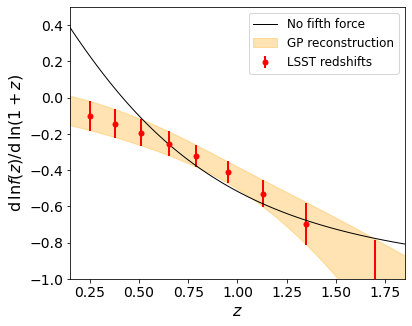

In [36]:
# Plot derivative of fhat for GP
plt.figure(figsize=(6, 5))

plt.plot(z_range, dlnf_LCDM, color = 'black', label = 'No fifth force', linewidth = 1)


plt.errorbar(z_LSST, dlnf_mean_LSST_GP, yerr=err_dlnf_LSST_GP, fmt='.', markersize=10, elinewidth=2, 
             color = 'red', label = 'LSST redshifts')

plt.fill_between(
    fhat_reco['x'],
    dlnf_mean_GP - err_dlnf_GP,
     dlnf_mean_GP + err_dlnf_GP,
    color='orange',
    alpha=0.3,
    label = 'GP reconstruction'
)

plt.xlim(0.15,1.85)
plt.ylim(-1.,0.5)

plt.legend(fontsize = 12)

ticks = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75]

# Set the x-axis ticks
plt.xticks(ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\\mathrm{d}\,\ln f(z)/\\mathrm{d}\,\ln(1+z)$', fontsize = 16)